## ATMS 523 - Module 5
Module 5 Homework - SeungUk Kim

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
# import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

In [2]:
# Load radar_parameters.csv data
radar_param = pd.read_csv('./homework/radar_parameters.csv', index_col=[0])
radar_param

### Part 1. Linear Regression

* Linear Regression
* Compared with baseline prediction

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [3]:
# Split training-testing: 70-30
Xtrain, Xtest, ytrain, ytest = train_test_split(radar_param.iloc[:,0:6].values, radar_param.iloc[:,6].values,
                                                train_size=0.7, random_state=0)
# Fit linear regression                                                
model = LinearRegression(fit_intercept=False)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

In [4]:
# Baseline prediction
# Z = 200 * (R**1.6). Thus, R = (Z/200)**(1/1.6)
# Zh = 10 * log10(Z). Thus, Z = 10**(Zh/10)
ypred_base = ((10**(Xtest[:,0]/10))/200)**(1/1.6)

In [134]:
from sklearn import metrics

print('Linear Regression')
print('R2 = ', metrics.r2_score(ypred, ytest))
print('RMSE = ', np.sqrt(metrics.mean_squared_error(ypred, ytest)), '\n')

print('Baseline Prediction')
print('R2 = ', metrics.r2_score(ypred_base, ytest))
print('RMSE = ', np.sqrt(metrics.mean_squared_error(ypred_base, ytest)))

Linear Regression
R2 =  0.9838061454436873
RMSE =  1.0492247752870645

Baseline Prediction
R2 =  0.23518915998899104
RMSE =  7.3523877227693095


Text(0.5, 0, 'Estimated R')

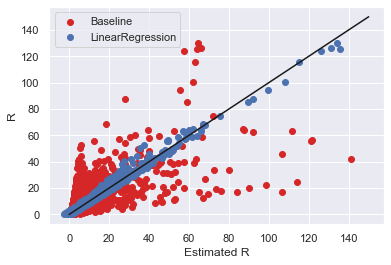

In [144]:
plt.plot([0,150],[0,150],'k')
plt.scatter(ypred_base, ytest, color='tab:red', label='Baseline')
plt.scatter(ypred, ytest, label='LinearRegression')
plt.legend()
plt.ylabel('R')
plt.xlabel('Estimated R')

Above shows that linear regression can outperform baseline prediction.

### Part 2. Grid Search

* Polynomial model for the order from 0 to 9

In [159]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import GridSearchCV

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

param_grid = {'polynomialfeatures__degree': np.arange(10),
              'linearregression__fit_intercept': [True, False],
              'linearregression__normalize': [True, False]}

grid = GridSearchCV(PolynomialRegression(), param_grid, cv=7, n_jobs=-1)

In [160]:
grid.fit(Xtrain, ytrain)

/opt/miniconda3/envs/py38/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/opt/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


GridSearchCV(cv=7,
             estimator=Pipeline(steps=[('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'linearregression__fit_intercept': [True, False],
                         'linearregression__normalize': [True, False],
                         'polynomialfeatures__degree': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])})

In [161]:
grid.best_params_

{'linearregression__fit_intercept': True,
 'linearregression__normalize': False,
 'polynomialfeatures__degree': 2}

In [23]:
model = grid.best_estimator_

In [24]:
y_test_gs = model.fit(Xtrain,ytrain).predict(Xtest)

/opt/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Polynomial Model (order=2)
R2 =  0.9994332634885356
RMSE =  0.1989099694490433 

Linear Regression
R2 =  0.9838061454436873
RMSE =  1.0492247752870645


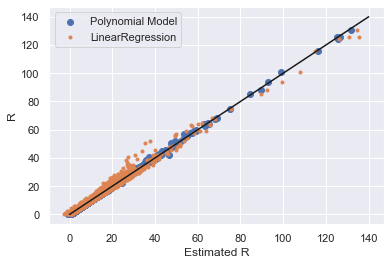

In [145]:
plt.plot([0,140],[0,140],'k')
plt.scatter(y_test_gs,ytest, label='Polynomial Model')
plt.scatter(ypred, ytest, marker='.', label='LinearRegression')
plt.legend()
plt.ylabel('R')
plt.xlabel('Estimated R')

print('Polynomial Model (order=2)')
print('R2 = ', metrics.r2_score(y_test_gs, ytest))
print('RMSE = ', np.sqrt(metrics.mean_squared_error(y_test_gs, ytest)), '\n')

print('Linear Regression')
print('R2 = ', metrics.r2_score(ypred, ytest))
print('RMSE = ', np.sqrt(metrics.mean_squared_error(ypred, ytest)))

Above shows that polynomial model can outperform linear regression

### Part 3. Random Forest

* Random Forest Regressor with Grid Search

In [85]:
from sklearn.ensemble import RandomForestRegressor

param_grid_rf = {'bootstrap': [True, False],  
                 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],  
                 'max_features': ['auto', 'sqrt'],  
                 'min_samples_leaf': [1, 2, 4],  
                 'min_samples_split': [2, 5, 10],  }

# Grid Search. Set scoring metric as R2. Using all available nodes. 
grid_rf = GridSearchCV(RandomForestRegressor(), param_grid_rf, scoring="r2", n_jobs=-1) 

In [151]:
# Save model
# import joblib
# filename = 'rf_model.sav'
# joblib.dump(grid_rf, filename)

['rf_model.sav']

In [147]:
grid_rf.fit(Xtrain, ytrain)

/opt/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100,
                                       None],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='r2')

In [152]:
model_rf = grid_rf.best_estimator_
y_test_rf = model_rf.fit(Xtrain,ytrain).predict(Xtest)

/opt/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Random Forest
R2 =  0.9579399329533697
RMSE =  1.6404019303397326 

Polynomial Model (order=2)
R2 =  0.9994332634885356
RMSE =  0.1989099694490433


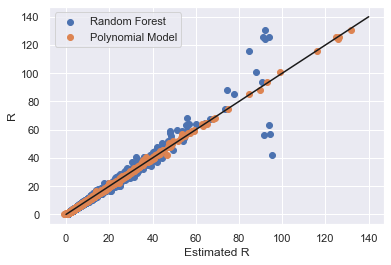

In [154]:
plt.plot([0,140],[0,140],'k')
plt.scatter(y_test_rf, ytest, label='Random Forest')
plt.scatter(y_test_gs, ytest, label='Polynomial Model')
plt.legend()
plt.ylabel('R')
plt.xlabel('Estimated R')

print('Random Forest')
print('R2 = ', metrics.r2_score(y_test_rf, ytest))
print('RMSE = ', np.sqrt(metrics.mean_squared_error(y_test_rf, ytest)), '\n')

print('Polynomial Model (order=2)')
print('R2 = ', metrics.r2_score(y_test_gs, ytest))
print('RMSE = ', np.sqrt(metrics.mean_squared_error(y_test_gs, ytest)))

Random Forest regressor misses lots of values when R becomes larger. It can only beat baseline prediction.

In [155]:
print('Linear Regression')
print('R2 = ', metrics.r2_score(ypred, ytest))
print('RMSE = ', np.sqrt(metrics.mean_squared_error(ypred, ytest)), '\n')

print('Baseline Prediction')
print('R2 = ', metrics.r2_score(ypred_base, ytest))
print('RMSE = ', np.sqrt(metrics.mean_squared_error(ypred_base, ytest)), '\n')

print('Polynomial Model (order=2)')
print('R2 = ', metrics.r2_score(y_test_gs, ytest))
print('RMSE = ', np.sqrt(metrics.mean_squared_error(y_test_gs, ytest)), '\n')

print('Random Forest')
print('R2 = ', metrics.r2_score(y_test_rf, ytest))
print('RMSE = ', np.sqrt(metrics.mean_squared_error(y_test_rf, ytest)))


Linear Regression
R2 =  0.9838061454436873
RMSE =  1.0492247752870645 

Baseline Prediction
R2 =  0.23518915998899104
RMSE =  7.3523877227693095 

Polynomial Model (order=2)
R2 =  0.9994332634885356
RMSE =  0.1989099694490433 

Random Forest
R2 =  0.9579399329533697
RMSE =  1.6404019303397326


To summarize, in terms of $R^2$ and $RMSE$, 2nd order Polynomial Model performs the best, followed by Linear Regression, Random Forest Regression, and Baseline Prediction.

Now, let's try is there any difference in using "Randomized Search", instead of "Grid Search"

In [162]:
from sklearn.model_selection import RandomizedSearchCV

grid_rf2 = RandomizedSearchCV(RandomForestRegressor(), param_grid_rf, n_iter=100, scoring="r2", n_jobs=-1)

In [163]:
grid_rf2.fit(Xtrain, ytrain)

/opt/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomizedSearchCV(estimator=RandomForestRegressor(), n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10]},
                   scoring='r2')

In [164]:
model_rf2 = grid_rf2.best_estimator_
y_test_rf2 = model_rf2.fit(Xtrain,ytrain).predict(Xtest)

/opt/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Random Forest - Grid Search
R2 =  0.9579399329533697
RMSE =  1.6404019303397326 

Random Forest - Randomized Search
R2 =  0.9478364396812916
RMSE =  1.851026875075819 



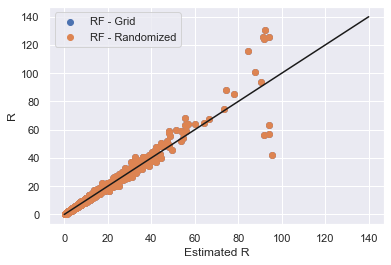

In [166]:
plt.plot([0,140],[0,140],'k')
plt.scatter(y_test_rf, ytest, label='RF - Grid')
plt.scatter(y_test_rf, ytest, label='RF - Randomized')
plt.legend()
plt.ylabel('R')
plt.xlabel('Estimated R')

print('Random Forest - Grid Search')
print('R2 = ', metrics.r2_score(y_test_rf, ytest))
print('RMSE = ', np.sqrt(metrics.mean_squared_error(y_test_rf, ytest)), '\n')

print('Random Forest - Randomized Search')
print('R2 = ', metrics.r2_score(y_test_rf2, ytest))
print('RMSE = ', np.sqrt(metrics.mean_squared_error(y_test_rf2, ytest)), '\n')

Looks almost identical.